# This notebook contains data analysis, visualizations, and model evaluations for bakery daily sales.

In [1]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Data Preparation
df = pd.read_csv('Bakery sales.csv', parse_dates=['date'])
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


**Here we have a datset that contient these columns : {'date': 'Date', 'unit_price': 'daily_sales'} and we are looking for daily sales, so we Add up all the "Unit Price" achieved in a day to get the "Daily Sales" and then keep only the "Daily Sales" column because that is only what we will need**

In [3]:
df['unit_price'] = df['unit_price'].str.replace(',', '.').str.replace(' €', '').astype(float)
df.drop(columns=['ticket_number', 'article', 'Quantity', 'Unnamed: 0'], inplace=True)
df['date'] = pd.to_datetime(df['date'])
data = df.groupby('date')['unit_price'].sum()
df_result = pd.DataFrame(data, columns=['unit_price'])
df_result.reset_index(inplace=True)
df_result.rename(columns={'date': 'Date', 'unit_price': 'daily_sales'}, inplace=True)
df_result.head()

,Date,daily_sales
0,2021-01-02,716.95
1,2021-01-03,782.85
2,2021-01-04,340.00
3,2021-01-05,424.65
4,2021-01-07,428.30


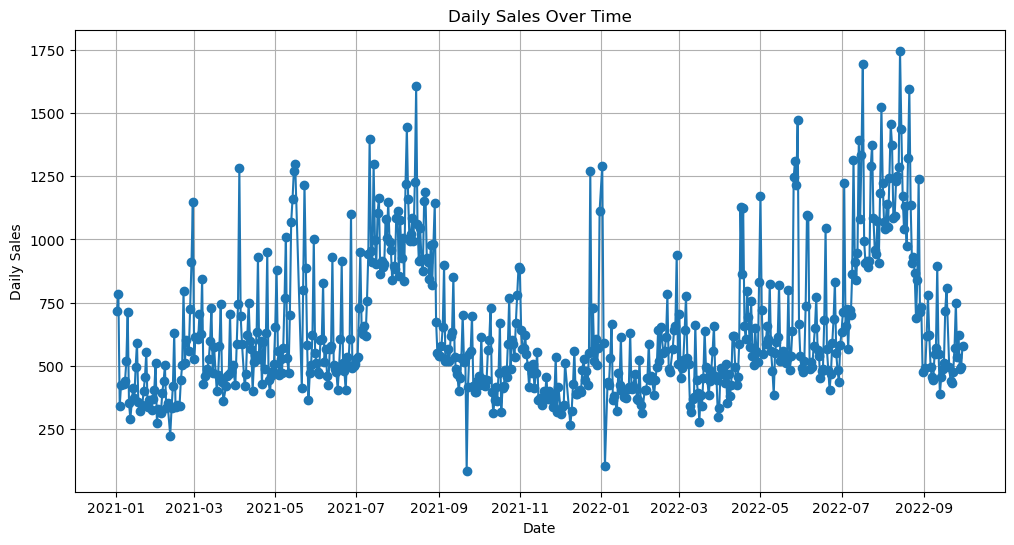

In [4]:
# Visualize the Data
plt.figure(figsize=(12, 6))
plt.plot(df_result['Date'], df_result['daily_sales'], marker='o', linestyle='-')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.grid(True)
plt.show()

**So this is the daily sales of the bakery over almost 2 years 2021/01/02 to 2022/09/30, we can notice the seasonality**

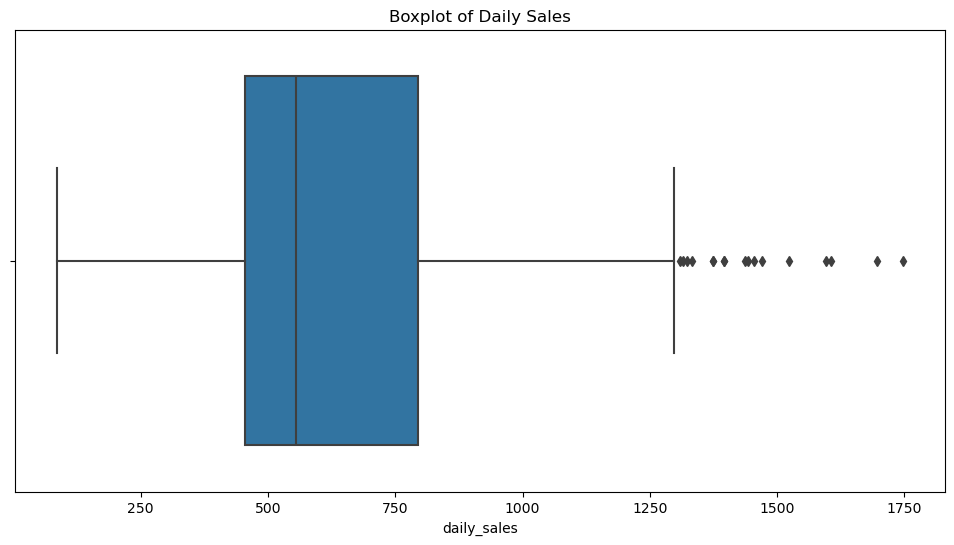

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_result['daily_sales'])
plt.title('Boxplot of Daily Sales')
plt.show()

**Here we can analyse the medium, max, min, quarter ... of daily sales**

In [6]:
# Import models from Models.ipynb
from models import LSTMModel
from models import GRUModel
from models import CNNLSTMModel
from models import TransformerModel
from models import ArimaModel

importing Jupyter notebook from Models.ipynb


**All the models are saved in models folder**

# Preparation for devloping (ARIMA) machine learning model

# Arima Model

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [8]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df_result['daily_sales'])

1. ADF :  -3.139371793023047
2. P-Value :  0.023773409780307654
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression: 585
5. Critical Values :
	 1% :  -3.4415777369651717
	 5% :  -2.866493255736561
	 10% :  -2.569407951640003


**The time series is likely stationary at the 5% significance level, meaning that the series does not have a unit root and is stable over time, also p-Value is less than 0.005 and that's mean that the data is stasionary**

In [9]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA  # Updated import
from math import sqrt

In [10]:
# Split the data into train and test sets
train = df_result.iloc[:-22]
test = df_result.iloc[-22:]

In [11]:
# Create an instance of the ArimaModel class
arima_model = ArimaModel(train, test, order=(5, 1, 5))

In [12]:
# Fit the model
arima_model.fit()

In [13]:
# Make predictions
predictions = arima_model.predict()

**!!! The test error & the visualisation of (test prediction vs actual) of all the models are at the end of the notebook !!!**

# Preparation for devloping predictive deep learning models

In [14]:
# Split Data into Train and Test Sets
train_size = int(len(df_result) * 0.8)
train, test = df_result['daily_sales'][:train_size], df_result['daily_sales'][train_size:]

In [15]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_result['daily_sales'] = scaler.fit_transform(df_result[['daily_sales']])
sequence_length = 10

In [16]:
# time series sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [17]:
# feature X and target y
X, y = create_sequences(df_result['daily_sales'].values, sequence_length)

In [18]:
# Transformation (X & y) to pyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [19]:
# Spliting the data to train & test groups
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
# Transformation (train & test of X & y) to pyTorch dataset and loader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
# Choosing parameters of the models
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

# LSTM

In [22]:
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [23]:
# Choosing the loss function & the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [24]:
# Initialize an empty list to store evaluation errors
eval_errors = []
num_epochs = 100
# Training loop
for epoch in range(num_epochs):
    # Training steps (not fully shown)
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, sequence_length, input_size)
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation steps
    lstm_model.eval()
    with torch.no_grad():
        y_pred_lstm = []
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, sequence_length, input_size)
            outputs = lstm_model(inputs)
            y_pred_lstm.extend(outputs.cpu().numpy())
        
        # Calculate MSE for this epoch and append to eval_errors
        mse = mean_squared_error(y_test, y_pred_lstm)
        eval_errors.append(mse)
    
    # Optionally, print or log the MSE for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse}')

Epoch [1/100], MSE: 0.039961159229278564
Epoch [2/100], MSE: 0.04294758662581444
Epoch [3/100], MSE: 0.036068446934223175
Epoch [4/100], MSE: 0.03296927735209465
Epoch [5/100], MSE: 0.026407701894640923
Epoch [6/100], MSE: 0.01833045855164528
Epoch [7/100], MSE: 0.017560137435793877
Epoch [8/100], MSE: 0.020039482042193413
Epoch [9/100], MSE: 0.017932280898094177
Epoch [10/100], MSE: 0.018421674147248268
Epoch [11/100], MSE: 0.018689237534999847
Epoch [12/100], MSE: 0.017955997958779335
Epoch [13/100], MSE: 0.017175622284412384
Epoch [14/100], MSE: 0.01797023043036461
Epoch [15/100], MSE: 0.018079396337270737
Epoch [16/100], MSE: 0.017228325828909874
Epoch [17/100], MSE: 0.018999960273504257
Epoch [18/100], MSE: 0.01725894771516323
Epoch [19/100], MSE: 0.01805795542895794
Epoch [20/100], MSE: 0.019233841449022293
Epoch [21/100], MSE: 0.017201954498887062
Epoch [22/100], MSE: 0.01765269599854946
Epoch [23/100], MSE: 0.019065888598561287
Epoch [24/100], MSE: 0.01666572317481041
Epoch [25

# CNN LSTM

In [25]:
# Train and Evaluate CNN-LSTM Model
cnn_lstm_model = CNNLSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

In [26]:
# Training loop
eval_errors_cnn_lstm = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, sequence_length, input_size)
        outputs = cnn_lstm_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation loop
    cnn_lstm_model.eval()
    with torch.no_grad():
        y_pred_cnn_lstm = []
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, sequence_length, input_size)
            outputs = cnn_lstm_model(inputs)
            y_pred_cnn_lstm.extend(outputs.cpu().numpy())
        
        # Calculate MSE for this epoch and append to eval_errors_cnn_lstm
        mse_cnn_lstm = mean_squared_error(y_test, y_pred_cnn_lstm)
        eval_errors_cnn_lstm.append(mse_cnn_lstm)
    
    # Optionally, print or log the MSE for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE (CNN-LSTM): {mse_cnn_lstm}')

Epoch [1/100], MSE (CNN-LSTM): 0.028520626947283745
Epoch [2/100], MSE (CNN-LSTM): 0.01811039261519909
Epoch [3/100], MSE (CNN-LSTM): 0.028380798175930977
Epoch [4/100], MSE (CNN-LSTM): 0.01770382560789585
Epoch [5/100], MSE (CNN-LSTM): 0.019061006605625153
Epoch [6/100], MSE (CNN-LSTM): 0.015836993232369423
Epoch [7/100], MSE (CNN-LSTM): 0.015046975575387478
Epoch [8/100], MSE (CNN-LSTM): 0.017891287803649902
Epoch [9/100], MSE (CNN-LSTM): 0.014606403186917305
Epoch [10/100], MSE (CNN-LSTM): 0.014546867460012436
Epoch [11/100], MSE (CNN-LSTM): 0.014679817482829094
Epoch [12/100], MSE (CNN-LSTM): 0.015253200195729733
Epoch [13/100], MSE (CNN-LSTM): 0.015240768902003765
Epoch [14/100], MSE (CNN-LSTM): 0.015777748078107834
Epoch [15/100], MSE (CNN-LSTM): 0.01577341929078102
Epoch [16/100], MSE (CNN-LSTM): 0.013556434772908688
Epoch [17/100], MSE (CNN-LSTM): 0.0125374561175704
Epoch [18/100], MSE (CNN-LSTM): 0.012101398780941963
Epoch [19/100], MSE (CNN-LSTM): 0.01528081949800253
Epoch [2

# GRU

In [27]:
# Train and Evaluate GRU Model
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

In [28]:
# Training loop
eval_errors_gru = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, sequence_length, input_size)
        outputs = gru_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation loop
    gru_model.eval()
    with torch.no_grad():
        y_pred_gru = []
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, sequence_length, input_size)
            outputs = gru_model(inputs)
            y_pred_gru.extend(outputs.cpu().numpy())
        
        # Calculate MSE for this epoch and append to eval_errors_gru_model
        mse_gru = mean_squared_error(y_test, y_pred_gru)
        eval_errors_gru.append(mse_gru)
    
    # Optionally, print or log the MSE for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE (CNN-LSTM): {mse_gru}')

Epoch [1/100], MSE (CNN-LSTM): 0.03274070844054222
Epoch [2/100], MSE (CNN-LSTM): 0.035105716437101364
Epoch [3/100], MSE (CNN-LSTM): 0.030561145395040512
Epoch [4/100], MSE (CNN-LSTM): 0.032838232815265656
Epoch [5/100], MSE (CNN-LSTM): 0.02352829836308956
Epoch [6/100], MSE (CNN-LSTM): 0.019997598603367805
Epoch [7/100], MSE (CNN-LSTM): 0.018646294251084328
Epoch [8/100], MSE (CNN-LSTM): 0.017391271889209747
Epoch [9/100], MSE (CNN-LSTM): 0.01678638719022274
Epoch [10/100], MSE (CNN-LSTM): 0.017716845497488976
Epoch [11/100], MSE (CNN-LSTM): 0.016487209126353264
Epoch [12/100], MSE (CNN-LSTM): 0.016415473073720932
Epoch [13/100], MSE (CNN-LSTM): 0.016168026253581047
Epoch [14/100], MSE (CNN-LSTM): 0.01733211614191532
Epoch [15/100], MSE (CNN-LSTM): 0.017390767112374306
Epoch [16/100], MSE (CNN-LSTM): 0.017824361100792885
Epoch [17/100], MSE (CNN-LSTM): 0.016424328088760376
Epoch [18/100], MSE (CNN-LSTM): 0.015644637867808342
Epoch [19/100], MSE (CNN-LSTM): 0.019506268203258514
Epoch 

# Transformer

In [29]:
# Train and Evaluate Transformer Model without external data
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1
num_epochs = 100
transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, nhead=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

In [30]:
# Training loop
eval_errors_transformer = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.view(-1, sequence_length, input_size)  # Reshape inputs to (batch_size, sequence_length, input_size)
        outputs = transformer_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Print loss occasionally
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.7f}')
    
    # Evaluation loop
    transformer_model.eval()
    with torch.no_grad():
        y_pred_transformer = []
        for inputs, _ in test_loader:
            inputs = inputs.view(-1, sequence_length, input_size)
            outputs = transformer_model(inputs)
            y_pred_transformer.extend(outputs.cpu().numpy())

        # Calculate MSE for this epoch and append to eval_errors_transformer
        mse_transformer = mean_squared_error(y_test, y_pred_transformer)
        eval_errors_transformer.append(mse_transformer)
    
    # Optionally, print or log the MSE for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE (Transformer): {mse_transformer}')

Epoch [1/100], MSE (Transformer): 0.09000030905008316
Epoch [2/100], MSE (Transformer): 0.06329715996980667
Epoch [3/100], MSE (Transformer): 0.06383288651704788
Epoch [4/100], MSE (Transformer): 0.05153879523277283
Epoch [5/100], MSE (Transformer): 0.05088968947529793
Epoch [6/100], MSE (Transformer): 0.030944041907787323
Epoch [7/100], MSE (Transformer): 0.015841644257307053
Epoch [8/100], MSE (Transformer): 0.01533404178917408
Epoch [9/100], MSE (Transformer): 0.016699621453881264
Epoch [10/100], Loss: 0.0292270
Epoch [10/100], MSE (Transformer): 0.01399286650121212
Epoch [11/100], MSE (Transformer): 0.014098855666816235
Epoch [12/100], MSE (Transformer): 0.01442358922213316
Epoch [13/100], MSE (Transformer): 0.013100055046379566
Epoch [14/100], MSE (Transformer): 0.011602383106946945
Epoch [15/100], MSE (Transformer): 0.011316009797155857
Epoch [16/100], MSE (Transformer): 0.010876771062612534
Epoch [17/100], MSE (Transformer): 0.012059465982019901
Epoch [18/100], MSE (Transformer)

# Preparation to integrate an external factor "is_holiday"

In [31]:
feature = pd.read_csv('vacance.csv', parse_dates=['Date'])
feature = feature.sort_values(by='Date')

df_result['daily_sales'] = scaler.inverse_transform(df_result[['daily_sales']])

merged_df = pd.merge(df_result, feature, on='Date', how='outer')
merged_df.dropna(inplace=True)

**Here we import 'vacance.csv' that it contains the holidays in France between 2021/01/02 to 2022/09/30, in the way that the holidays dates have "True" value, and than we merge it with our dataset**



**Now we will discover if this column "is_holiday" has an impact on the development of daily sales?**

In [32]:
train_size_imp = int(len(merged_df) * 0.8)
train_imp, test_imp = merged_df[:train_size_imp], merged_df[train_size_imp:]

Here we determine test and train group in order to use just train group to do this (َAvoid leakage)

In [33]:
# Analyze the importance of is_holiday feature
holiday_sales = train_imp[train_imp['is_holiday'] == True]
non_holiday_sales = train_imp[train_imp['is_holiday'] == False]

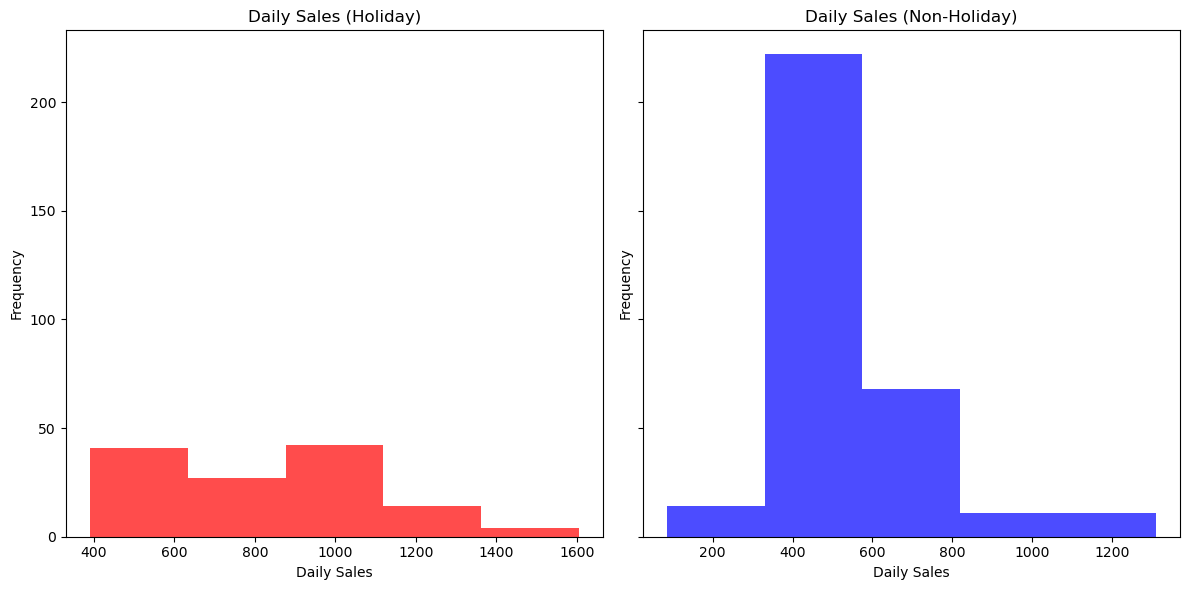

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1.hist(holiday_sales['daily_sales'], bins=5, color='r', alpha=0.7)
ax1.set_title('Daily Sales (Holiday)')
ax1.set_xlabel('Daily Sales')
ax1.set_ylabel('Frequency')

ax2.hist(non_holiday_sales['daily_sales'], bins=5, color='b', alpha=0.7)
ax2.set_title('Daily Sales (Non-Holiday)')
ax2.set_xlabel('Daily Sales')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Here we notice that the sales in holidays may reach 1600 euros and the high prices on holidays are considered more than non-holidays between 900 and 1600**

In [35]:
# Group by 'is_holiday' and calculate the mean of 'daily_sales'
mean_sales = train_imp.groupby('is_holiday')['daily_sales'].mean()

mean_holiday = mean_sales[True]
mean_non_holiday = mean_sales[False]

print(f"Mean daily_sales on holidays: {mean_holiday}")
print(f"Mean daily_sales on non-holidays: {mean_non_holiday}")

Mean daily_sales on holidays: 831.54140625
Mean daily_sales on non-holidays: 531.6465950920245


**So here we notice that the mean daily sales on holidays is more than on non-holidays, so we say that has an impact on the development of daily sales**

# Preparation for devloping (ARIMA) machine learning model with an external factor "is_holiday"

In [36]:
# Split the data into train and test sets
train = merged_df.iloc[:-22]
test = merged_df.iloc[-22:]
exog_train = merged_df['is_holiday'].iloc[:-22]
exog_test = merged_df['is_holiday'].iloc[-22:]

In [37]:
# Create an instance of the ArimaModelWithExternal class
arima_model_ex = ArimaModelWithExternal(train, test, exog_train, exog_test, order=(5, 1, 5))

In [38]:
# Fit the model
arima_model_ex.fit()

In [39]:
# Make predictions
predictions = arima_model_ex.predict()

# Preparation for devloping predictive deep learning models with an external factor "is_holiday"

In [40]:
scaler = MinMaxScaler()
merged_df['daily_sales'] = scaler.fit_transform(merged_df[['daily_sales']])
train_data, test_data = train_test_split(merged_df, test_size=0.2, shuffle=False)

In [41]:
class SalesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        self.sales = data['daily_sales'].values
        self.is_holiday = data['is_holiday'].astype(int).values

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        sales_seq = self.sales[idx:idx + self.seq_length]
        holiday_seq = self.is_holiday[idx:idx + self.seq_length]
        target = self.sales[idx + self.seq_length]
        return torch.FloatTensor(sales_seq), torch.FloatTensor(holiday_seq), torch.FloatTensor([target])

In [42]:
seq_length = 30
train_dataset = SalesDataset(train_data, seq_length)
test_dataset = SalesDataset(test_data, seq_length)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
input_dim = 1
hidden_dim = 50
num_layers = 2

# LSTM

In [45]:
lstm_model_with_external = LSTMModelWithExternal(input_dim, hidden_dim, num_layers)

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model_with_external.parameters(), lr=0.001)

In [47]:
num_epochs = 100
train_losses_LSTM_ex = []
lstm_model_with_external.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for sales_seq, holiday_seq, target in train_loader:
        sales_seq = sales_seq.unsqueeze(-1)
        output = lstm_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses_LSTM_ex.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}')

Epoch 1/100, Loss: 0.06419237064463752
Epoch 2/100, Loss: 0.029779818574232713
Epoch 3/100, Loss: 0.025756330828049352
Epoch 4/100, Loss: 0.022980368496584042
Epoch 5/100, Loss: 0.02174065009291683
Epoch 6/100, Loss: 0.02074191639465945
Epoch 7/100, Loss: 0.018399669057024375
Epoch 8/100, Loss: 0.016091325852487768
Epoch 9/100, Loss: 0.014952700518603836
Epoch 10/100, Loss: 0.013851352435137545
Epoch 11/100, Loss: 0.014986613732097405
Epoch 12/100, Loss: 0.014418360777199268
Epoch 13/100, Loss: 0.013615131112081664
Epoch 14/100, Loss: 0.01356213290377387
Epoch 15/100, Loss: 0.013681266357057862
Epoch 16/100, Loss: 0.014107374274837119
Epoch 17/100, Loss: 0.013409285739596401
Epoch 18/100, Loss: 0.013179954041593842
Epoch 19/100, Loss: 0.014015150788639272
Epoch 20/100, Loss: 0.01380706688256136
Epoch 21/100, Loss: 0.01297032686748675
Epoch 22/100, Loss: 0.01350170377242778
Epoch 23/100, Loss: 0.013416857259081942
Epoch 24/100, Loss: 0.013245407292353255
Epoch 25/100, Loss: 0.0143376308

In [48]:
# Evaluate LSTM Model with external data
lstm_model_with_external.eval()
test_losses_LSTM = []
actuals_LSTM  = []
predictions_LSTM  = []

with torch.no_grad():
    for sales_seq, holiday_seq, target in test_loader:
        sales_seq = sales_seq.unsqueeze(-1)
        output = lstm_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        test_losses_LSTM.append(loss.item())
        actuals_LSTM.extend(target.numpy())
        predictions_LSTM.extend(output.numpy())

print(f'Test Loss: {np.mean(test_losses_LSTM)}')

Test Loss: 0.010492775899668535


# CNN LSTM

In [49]:
cnn_lstm_model_with_external = CNNLSTMModelWithExternal(input_dim, hidden_dim, num_layers)

In [50]:
# Step 19: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_lstm_model_with_external.parameters(), lr=0.001)

In [51]:
num_epochs = 100
train_losses_CNN_LSTM_ex = []
cnn_lstm_model_with_external.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for sales_seq, holiday_seq, target in train_loader:
        sales_seq = sales_seq.unsqueeze(-1)  # Add input_dim dimension
        output = cnn_lstm_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses_CNN_LSTM_ex.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}')

Epoch 1/100, Loss: 0.031855393068066666
Epoch 2/100, Loss: 0.01568341438126351
Epoch 3/100, Loss: 0.016228371898510625
Epoch 4/100, Loss: 0.014578048073287522
Epoch 5/100, Loss: 0.015222810009228331
Epoch 6/100, Loss: 0.01403531658330134
Epoch 7/100, Loss: 0.013483313577515739
Epoch 8/100, Loss: 0.014091348109234656
Epoch 9/100, Loss: 0.013689704705029726
Epoch 10/100, Loss: 0.01403481257148087
Epoch 11/100, Loss: 0.013277910849345582
Epoch 12/100, Loss: 0.01410645223222673
Epoch 13/100, Loss: 0.013161548113982593
Epoch 14/100, Loss: 0.014147842469226037
Epoch 15/100, Loss: 0.012189556412132723
Epoch 16/100, Loss: 0.013403730067823614
Epoch 17/100, Loss: 0.012817809923685022
Epoch 18/100, Loss: 0.012760599975341133
Epoch 19/100, Loss: 0.012956196375723397
Epoch 20/100, Loss: 0.01208759767801634
Epoch 21/100, Loss: 0.012396079920498388
Epoch 22/100, Loss: 0.011143035388418607
Epoch 23/100, Loss: 0.012443116533436946
Epoch 24/100, Loss: 0.010818276471192283
Epoch 25/100, Loss: 0.01127682

In [52]:
# Evaluate CNN-LSTM Model with external data
cnn_lstm_model_with_external.eval()
test_losses_CNN_LSTM = []
actuals_CNN_LSTM = []
predictions_CNN_LSTM = []

with torch.no_grad():
    for sales_seq, holiday_seq, target in test_loader:
        sales_seq = sales_seq.unsqueeze(-1)
        output = cnn_lstm_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        test_losses_CNN_LSTM.append(loss.item())
        actuals_CNN_LSTM.extend(target.numpy())
        predictions_CNN_LSTM.extend(output.numpy())

print(f'Test Loss: {np.mean(test_losses_CNN_LSTM)}')

Test Loss: 0.013201805374895534


# GRU

In [53]:
# Train and Evaluate GRU Model with external data
gru_model_with_external = GRUModelWithExternal(input_dim, hidden_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_with_external.parameters(), lr=0.001)

In [54]:
# Training loop
num_epochs = 100
train_losses_GRU_ex = []
gru_model_with_external.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for sales_seq, holiday_seq, target in train_loader:
        sales_seq = sales_seq.unsqueeze(-1)
        output = gru_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses_GRU_ex.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}')

Epoch 1/100, Loss: 0.044208200249288766
Epoch 2/100, Loss: 0.019331275951117277
Epoch 3/100, Loss: 0.016419519603784596
Epoch 4/100, Loss: 0.01641609888922955
Epoch 5/100, Loss: 0.014962708610775215
Epoch 6/100, Loss: 0.014505610169310654
Epoch 7/100, Loss: 0.01404262859640377
Epoch 8/100, Loss: 0.014303012917350446
Epoch 9/100, Loss: 0.013646385532670788
Epoch 10/100, Loss: 0.012779360005099858
Epoch 11/100, Loss: 0.012935292907059193
Epoch 12/100, Loss: 0.0131391759163567
Epoch 13/100, Loss: 0.012379520572721958
Epoch 14/100, Loss: 0.012222073872440628
Epoch 15/100, Loss: 0.013665961035128151
Epoch 16/100, Loss: 0.014357600111647375
Epoch 17/100, Loss: 0.013257555597062622
Epoch 18/100, Loss: 0.013428205557699715
Epoch 19/100, Loss: 0.012751468191189426
Epoch 20/100, Loss: 0.013126016860561711
Epoch 21/100, Loss: 0.013155786819489939
Epoch 22/100, Loss: 0.01243084981771452
Epoch 23/100, Loss: 0.011522459398422922
Epoch 24/100, Loss: 0.011595716101250477
Epoch 25/100, Loss: 0.01265005

In [55]:
# Evaluate GRU Model with external data
gru_model_with_external.eval()
test_losses_GRU = []
actuals_GRU = []
predictions_GRU = []

with torch.no_grad():
    for sales_seq, holiday_seq, target in test_loader:
        sales_seq = sales_seq.unsqueeze(-1)
        output = gru_model_with_external(sales_seq, holiday_seq)
        loss = criterion(output, target)
        test_losses_GRU.append(loss.item())
        actuals_GRU.extend(target.numpy())
        predictions_GRU.extend(output.numpy())

print(f'Test Loss: {np.mean(test_losses_GRU)}')

Test Loss: 0.010952705517411232


# Evaluation with error metrics

# ARIMA model evaluation

# ARIMA 

In [56]:
# Evaluate the model
rmse = arima_model.evaluate()
print(f'RMSE: {rmse}')

RMSE: 111.97715485415394


In [57]:
mean = test['daily_sales'].mean()
print(f'mean: {mean}')

mean: 557.5386363636363


# ARIMA WITH "is_holiday"

In [58]:
# Evaluate the model
rmse = arima_model_ex.evaluate()
print(f'RMSE: {rmse}')

RMSE: 108.61340870941686


# LSTM model evaluation

# LSTM

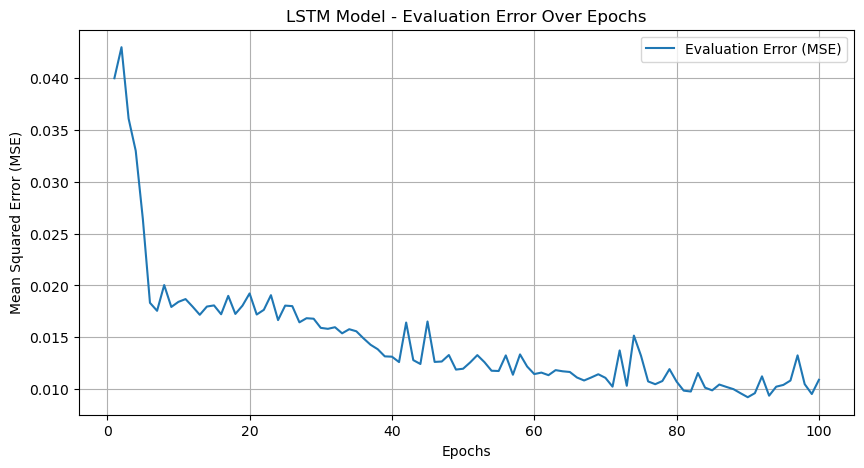

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), eval_errors, label='Evaluation Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LSTM Model - Evaluation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# LSTM WITH "is_holiday"

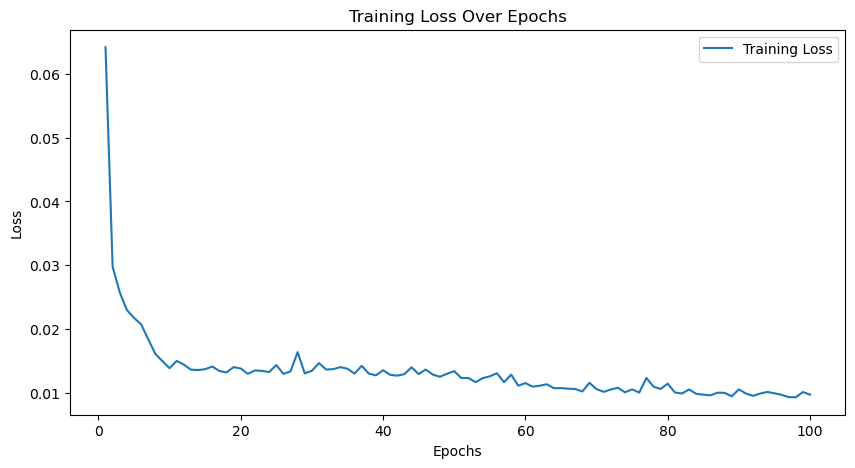

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_LSTM_ex, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# CNN-LSTM model evaluation

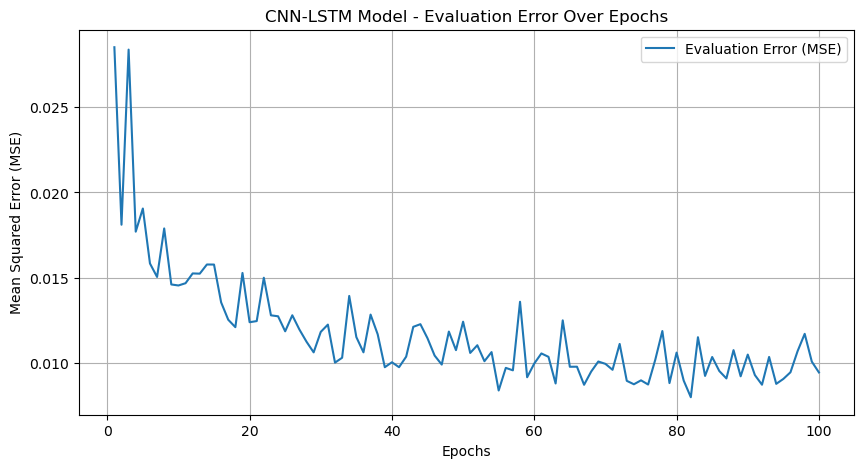

In [61]:
# After training loop, visualize evaluation errors over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), eval_errors_cnn_lstm, label='Evaluation Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('CNN-LSTM Model - Evaluation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# CNN LSTM WITH "is_holiday"

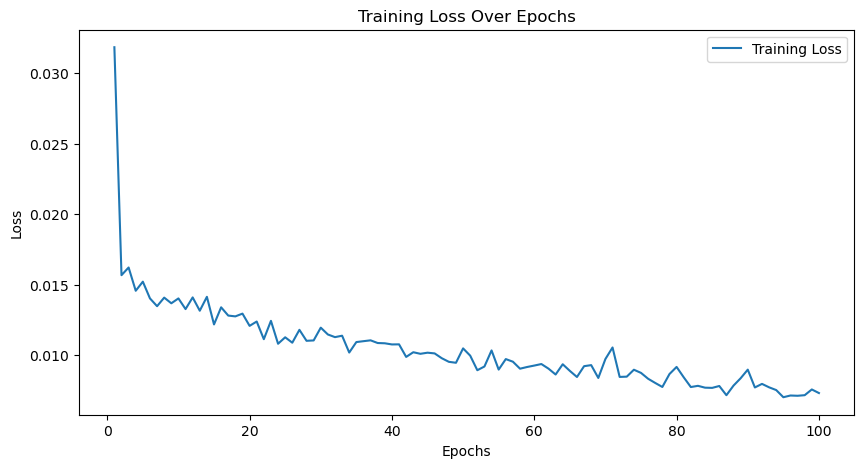

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_CNN_LSTM_ex, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# GRU model evaluation

# GRU

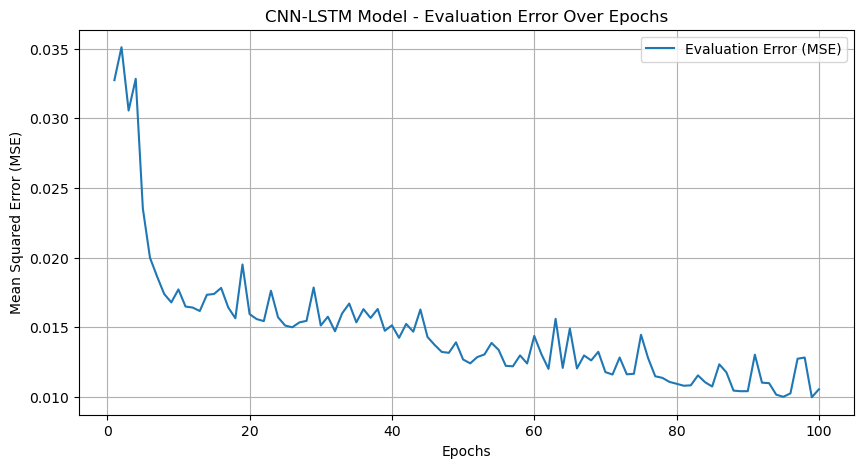

In [63]:
# After training loop, visualize evaluation errors over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), eval_errors_gru, label='Evaluation Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('CNN-LSTM Model - Evaluation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# GRU WITH "is_holiday"

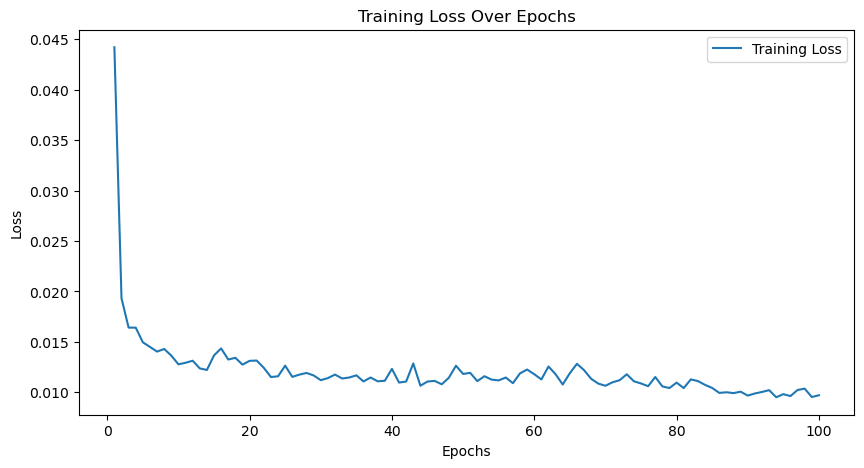

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_GRU_ex, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Transformer model evaluation

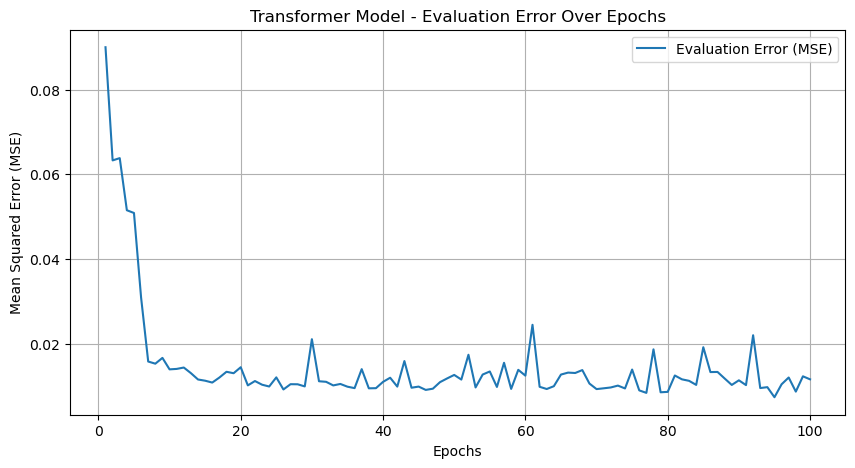

In [65]:
# After training loop, visualize evaluation errors over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), eval_errors_transformer, label='Evaluation Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Transformer Model - Evaluation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Compare performance 

# ARIMA

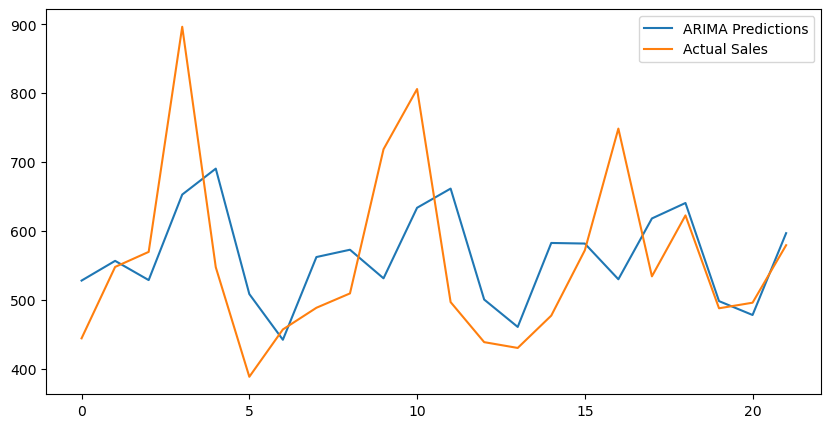

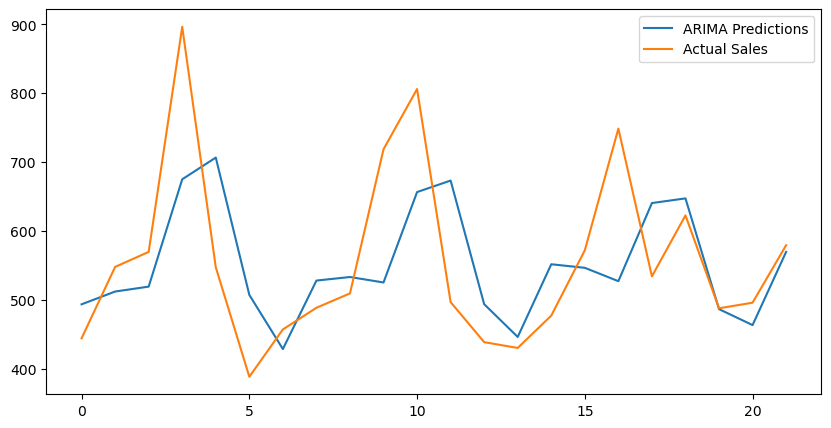

In [66]:
# Plot the predictions
arima_model.plot_predictions()

# Plot the predictions
arima_model_ex.plot_predictions()

# LSTM

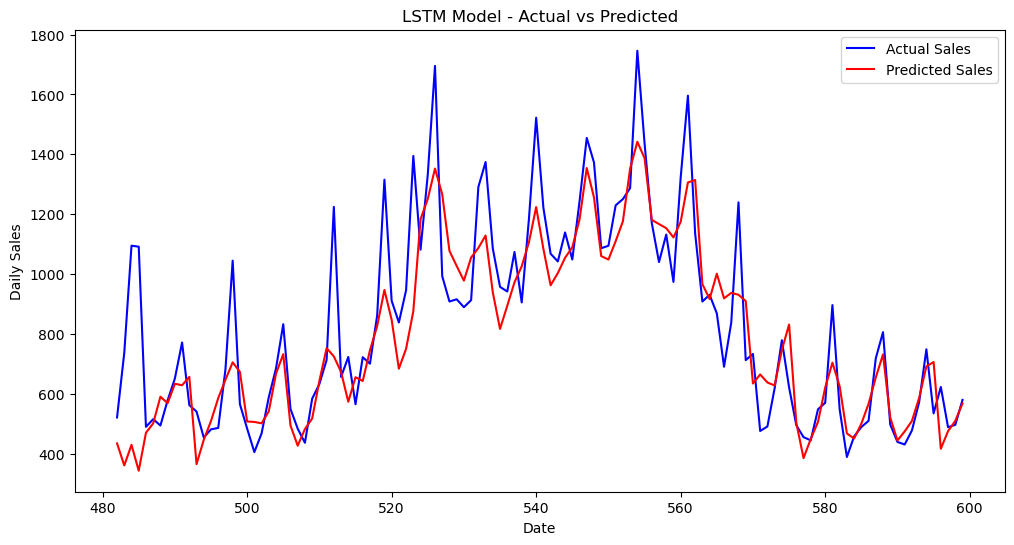

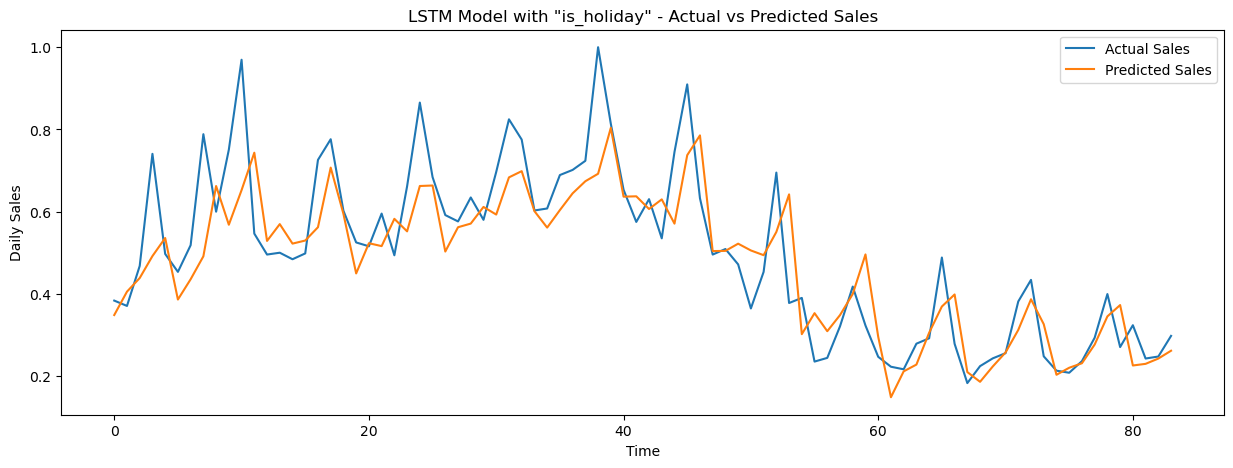

In [67]:
y_pred_inv_lstm = scaler.inverse_transform(np.array(y_pred_lstm).reshape(-1, 1))
y_test_inv_lstm = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Visualize LSTM Results without external data
plt.figure(figsize=(12, 6))
plt.plot(df_result.index[-len(y_test):], y_test_inv_lstm, color='blue', label='Actual Sales')
plt.plot(df_result.index[-len(y_test):], y_pred_inv_lstm, color='red', label='Predicted Sales')
plt.title('LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.show()

# Visualize LSTM Results with external data
plt.figure(figsize=(15, 5))
plt.plot(actuals_LSTM, label='Actual Sales')
plt.plot(predictions_LSTM, label='Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Daily Sales')
plt.title('LSTM Model with "is_holiday" - Actual vs Predicted Sales')
plt.legend()
plt.show()

# CNN LSTM

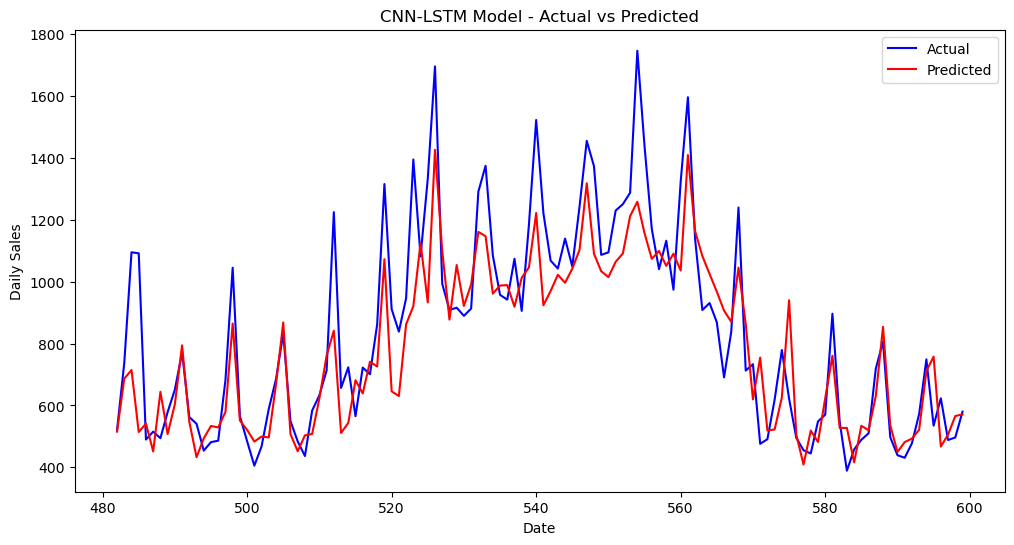

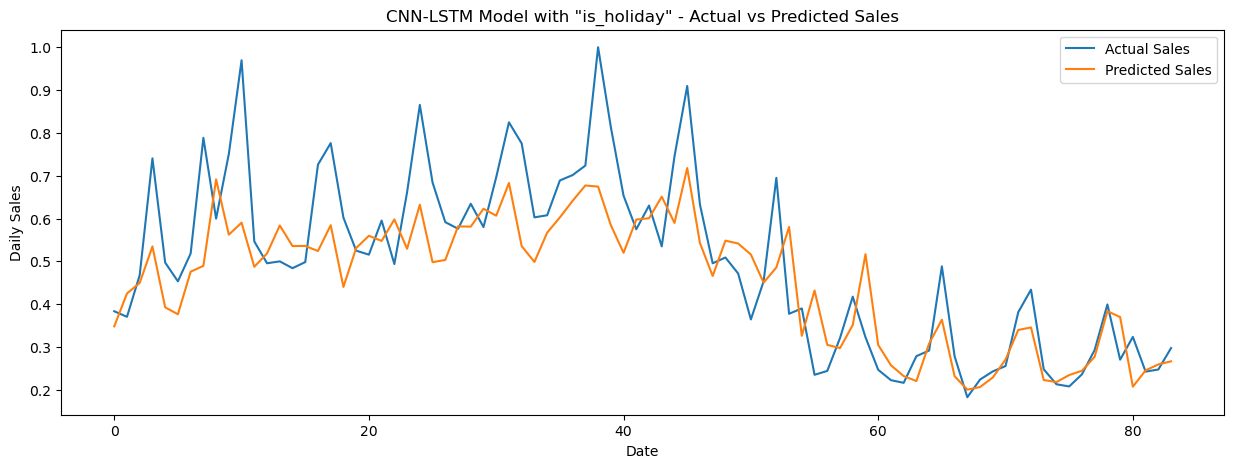

In [68]:
y_pred_inv_CNN_LSTM = scaler.inverse_transform(np.array(y_pred_cnn_lstm).reshape(-1, 1))
y_test_inv_CNN_LSTM = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Visualize CNN-LSTM Results without external data
plt.figure(figsize=(12, 6))
plt.plot(df_result.index[-len(y_test):], y_test_inv_CNN_LSTM, color='blue', label='Actual')
plt.plot(df_result.index[-len(y_test):], y_pred_inv_CNN_LSTM, color='red', label='Predicted')
plt.title('CNN-LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.show()

# Visualize CNN-LSTM Results with external data
plt.figure(figsize=(15, 5))
plt.plot(actuals_CNN_LSTM, label='Actual Sales')
plt.plot(predictions_CNN_LSTM, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('CNN-LSTM Model with "is_holiday" - Actual vs Predicted Sales')
plt.legend()
plt.show()

# GRU

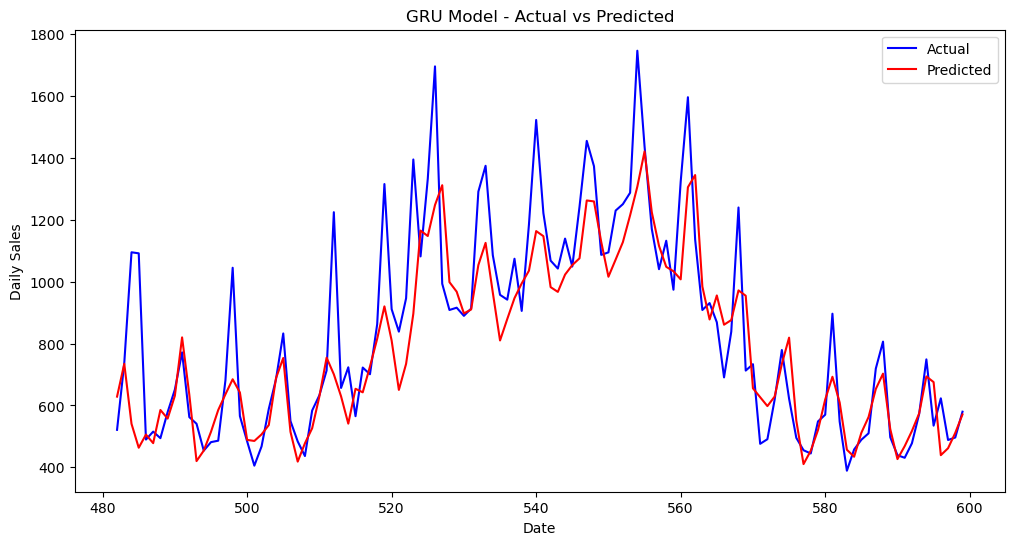

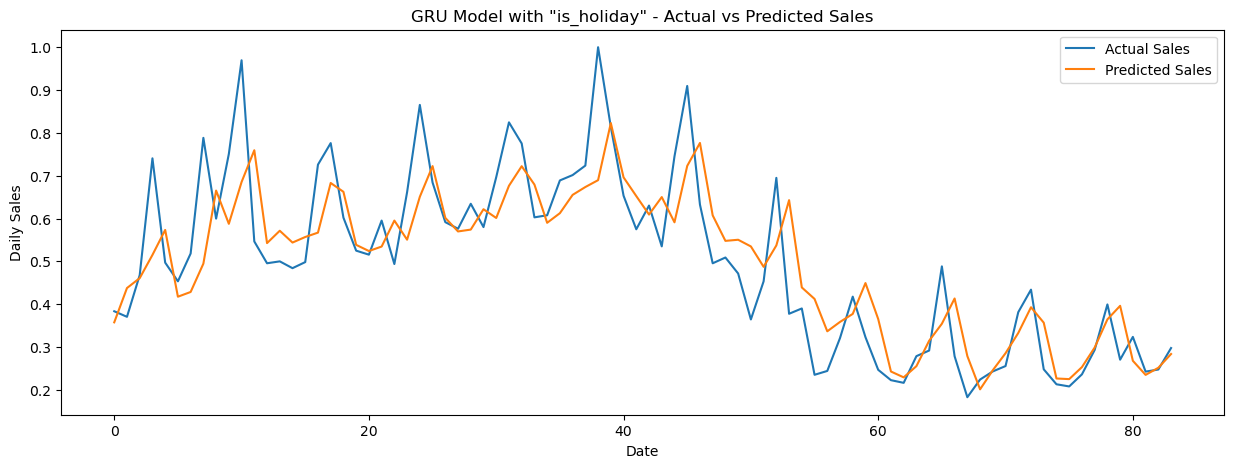

In [69]:
y_pred_inv_GRU = scaler.inverse_transform(np.array(y_pred_gru).reshape(-1, 1))
y_test_inv_GRU = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Visualize GRU Results without external data
plt.figure(figsize=(12, 6))
plt.plot(df_result.index[-len(y_test):], y_test_inv_GRU, color='blue', label='Actual')
plt.plot(df_result.index[-len(y_test):], y_pred_inv_GRU, color='red', label='Predicted')
plt.title('GRU Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.show()

# Visualize GRU Results with external data
plt.figure(figsize=(15, 5))
plt.plot(actuals_GRU, label='Actual Sales')
plt.plot(predictions_GRU, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('GRU Model with "is_holiday" - Actual vs Predicted Sales')
plt.legend()
plt.show()

# Transformer

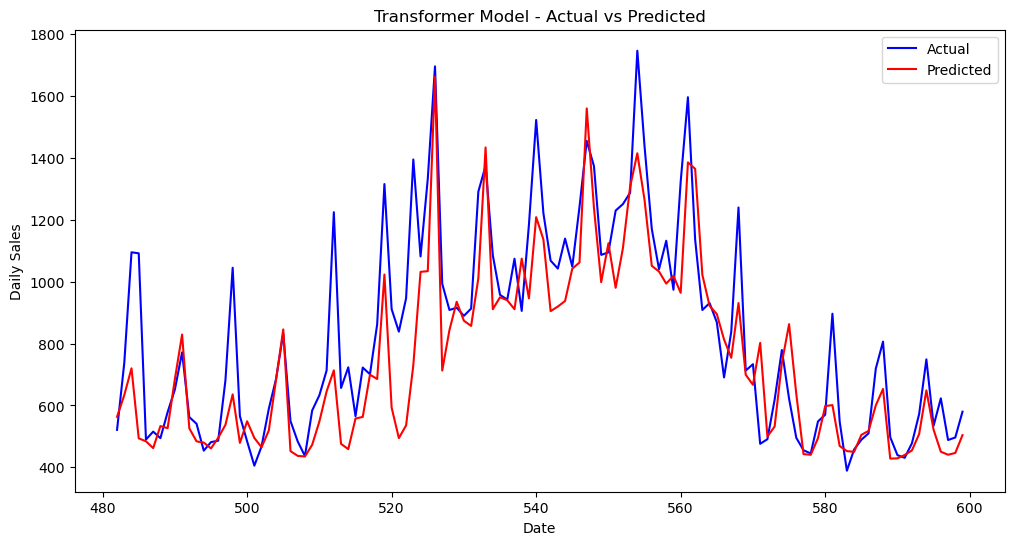

In [70]:
y_pred_inv_Transformer = scaler.inverse_transform(np.array(y_pred_transformer).reshape(-1, 1))
y_test_inv_Transformer = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Visualize Transformer Results without external data
plt.figure(figsize=(12, 6))
plt.plot(df_result.index[-len(y_test):], y_test_inv_Transformer, color='blue', label='Actual')
plt.plot(df_result.index[-len(y_test):], y_pred_inv_Transformer, color='red', label='Predicted')
plt.title('Transformer Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.show()

**Generally, I notice that all models record good predictions . Deep learning models have generally recorded favorable predictions. The Transformer model showed the best predictions, followed by GRU, CNN LSTM, and LSTM. To improve the results of GRU, CNN LSTM, and LSTM, an external variable 'is_holiday' was introduced to see if predictions would improve. Indeed, I noticed through forecasting results with the test set that the outcome has somewhat improved with the model LSTM and GRU**